In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics 
from keras.layers.core import Dense, Activation, Dropout

plt.rcParams['font.sans-serif'] = ['SimHei']

C:\Users\26755\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\26755\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\26755\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\26755\Anaconda3\lib\site-packages\tensorflow\python\framework\

# 数据处理

In [9]:
#timesteps = 72#构造x，为72个数据,表示每次用前72个数据作为一段
#predict_steps = 12#构造y，为12个数据，表示用后12个数据作为一段
#length = 288#预测多步，预测288个数据，每次预测12个，想想要怎么构造预测才能满足288？
def Data_range(data,range_len):
    data.sort_values('时间')
    Time = data['时间']
    Values = data['容量']
    Values_new = []
    for i in range(0,len(data),range_len):
        values = round(np.mean(Values[i:i+range_len]),2)
        Values_new.append(values)
    return Values_new
def create_dataset(dataset, timesteps=1000,predict_size=940):#构造数据集
    datax=[]#构造x
    datay=[]#构造y
    for each in range(len(dataset)-timesteps - predict_steps):
        x = dataset[each:each+timesteps,0]
        y = dataset[each+timesteps:each+timesteps+predict_steps,0]
        datax.append(x)
        datay.append(y)
    return datax, datay

In [7]:
def Model(trainx,trainy,timesteps):
    model = Sequential()
    model.add(LSTM(1,input_shape=(timesteps,1),return_sequences= True))
    model.add(Dropout(0.5))
    model.add(LSTM(50,return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(50,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(predict_steps))
    model.add(Activation("linear"))
    model.compile(loss="mean_squared_error",optimizer="adam")
    model.fit(trainx,trainy, epochs= 20, batch_size=50)
    return model

# 滚动检测

In [4]:
#predict滚动预测
#因为每次只能预测predict_steps个数据，但是我要预测length个数据，所以采用的就是循环预测的思路。每次预测的predict_steps个数据，添加到数据集中充当预测x，然后在预测新的predict_steps个y，再添加到预测x列表中，如此往复。最终预测出length个点。
def Predict(pre_init,timesteps,length,model):
    predict_xlist = []#添加预测x列表
    predict_y = []#添加预测y列表
    predict_xlist.extend(pre_init)#已经存在的最后timesteps个数据添加进列表，预测新值(比如已经有的数据从1,2,3到1000。现在要预测后面的数据，所以将784到1000的216个数据添加到列表中，预测新的所有的数据）
    while len(predict_y) < length:
        predictx = np.array(predict_xlist[-timesteps:])#从最新的predict_xlist取出timesteps个数据，预测新的predict_steps个数据（因为每次预测的y会添加到predict_xlist列表中，为了预测将来的值，所以每次构造的x要取这个列表中最后的timesteps个数据词啊性）
        predictx = np.reshape(predictx,(1,timesteps,1))#变换格式，适应LSTM模型
        #print("predictx"),print(predictx),print(predictx.shape)
        #预测新值
        lstm_predict = model.predict(predictx)
        #predict_list.append(train_predict)#新值y添加进列表，做x
        #滚动预测
        #print("lstm_predict"),print(lstm_predict[0])
        predict_xlist.extend(lstm_predict[0])#将新预测出来的predict_steps个数据，加入predict_xlist列表，用于下次预测
        # invert
        lstm_predict = scaler.inverse_transform(lstm_predict)
        predict_y.extend(lstm_predict[0])#预测的结果y，每次预测的36个数据，添加进去，直到预测所有的为止
    return predict_y

In [12]:
def result(predicted,train_data,test_data):
        
    plt.plot(test_data, label="真实", alpha=1.0)
    plt.plot(predicted, label="预测", alpha=1.0)
    plt.show()    
    
    predicted = pd.Series(list(predicted), index = range(len(train_data),len(train_data)+len(predicted)))
    data =  pd.Series(list(train_data)+(test_data))
    ax = data.plot(label="真实")
    predicted.plot(ax=ax, label="预测", alpha=1.0)

    ax.set_xlabel(U'时间序号')
    ax.set_ylabel(U'数值')
    plt.title("LSTM预测的结果")
    plt.legend()
    plt.show()


    print("误差MSE：",metrics.mean_squared_error(test_data, predicted))
    print("误差RMSE：",np.sqrt(metrics.mean_squared_error(test_data, predicted)))
    print("误差MAE：",metrics.mean_absolute_error(test_data, predicted))
    print("误差MAPE：",(np.mean(np.abs((test_data,predicted)/np.array(test_data))) * 100))

# 磁盘数据

Wall time: 0 ns
(101, 15)
Epoch 1/20
101/101 [==============================] - 3s 34ms/step - loss: 0.5027
Epoch 2/20
101/101 [==============================] - 0s 1ms/step - loss: 0.4848
Epoch 3/20
101/101 [==============================] - 0s 1ms/step - loss: 0.4605
Epoch 4/20
101/101 [==============================] - 0s 1ms/step - loss: 0.4264
Epoch 5/20
101/101 [==============================] - 0s 1ms/step - loss: 0.3699
Epoch 6/20
101/101 [==============================] - 0s 2ms/step - loss: 0.2860
Epoch 7/20
101/101 [==============================] - 0s 1ms/step - loss: 0.1809
Epoch 8/20
101/101 [==============================] - 0s 1ms/step - loss: 0.1613
Epoch 9/20
101/101 [==============================] - 0s 1ms/step - loss: 0.1475
Epoch 10/20
101/101 [==============================] - 0s 1ms/step - loss: 0.1003
Epoch 11/20
101/101 [==============================] - 0s 1ms/step - loss: 0.0948
Epoch 12/20
101/101 [==============================] - 0s 1ms/step - loss: 0.099

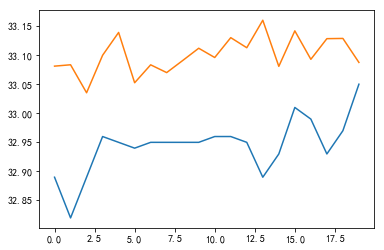

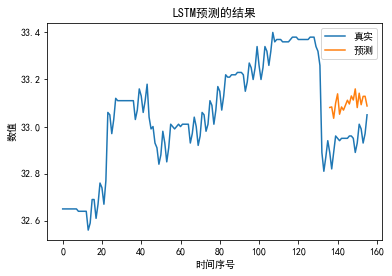

误差MSE： 0.02682419569662862
误差RMSE： 0.16378093813575686
误差MAE： 0.15577675628662035
误差MAPE： 100.23651152473715


In [14]:
%time
ratio = 20
data_d = pd.read_csv('d_buquan_disk.csv')
data_value = Data_range(data_d,36)
trainData = data_value[:len(data_value)-ratio]
testData = data_value[len(data_value)-ratio:]

train_data=np.array(trainData, dtype='float64')
train_data=train_data.reshape(-1,1)
#数据标准化
scaler = MinMaxScaler(feature_range=(0,1))
train_data = scaler.fit_transform(train_data)
train = train_data.copy()

timesteps = 15
predict_steps = 20
length = len(data_value)-len(train_data)

datax, datay = create_dataset(train_data, timesteps, predict_steps)
#print(datax)
trainx = np.array(datax)
trainy = np.array(datay)
print(trainx.shape)
##变换shape,以满足keras
trainx = np.reshape(trainx,(trainx.shape[0],timesteps,1))

model = Model(trainx,trainy,timesteps)
pre_init = train_data[train_data.shape[0]-timesteps:train_data.shape[0],0].tolist()
predict = Predict(pre_init,timesteps,length,model)
result(predict,trainData,testData)

(669, 15)
Epoch 1/20
669/669 [==============================] - 4s 6ms/step - loss: 0.3920
Epoch 2/20
669/669 [==============================] - 0s 666us/step - loss: 0.1646
Epoch 3/20
669/669 [==============================] - 0s 732us/step - loss: 0.0767
Epoch 4/20
669/669 [==============================] - 0s 720us/step - loss: 0.0643
Epoch 5/20
669/669 [==============================] - 1s 1ms/step - loss: 0.0576
Epoch 6/20
669/669 [==============================] - 0s 730us/step - loss: 0.0536
Epoch 7/20
669/669 [==============================] - 1s 1ms/step - loss: 0.0534
Epoch 8/20
669/669 [==============================] - 1s 868us/step - loss: 0.0471
Epoch 9/20
669/669 [==============================] - 0s 732us/step - loss: 0.0452
Epoch 10/20
669/669 [==============================] - 1s 812us/step - loss: 0.0425
Epoch 11/20
669/669 [==============================] - 1s 781us/step - loss: 0.0421
Epoch 12/20
669/669 [==============================] - 0s 727us/step - loss: 0.04

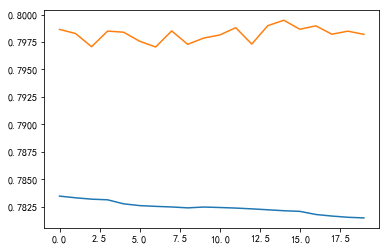

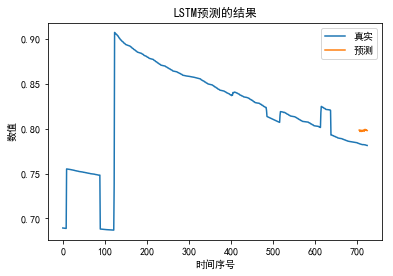

误差MSE： 0.00025128665057010986
误差RMSE： 0.015852023548118703
误差MAE： 0.01582357150035175
误差MAPE： 101.0112522644688


In [15]:
ratio = 20
data_hit = pd.read_csv('hit_buquan_disk.csv')
Values_hit_new = Data_range(data_hit,3)
data_miss = pd.read_csv('miss_buquan_disk.csv')
Values_miss_new = Data_range(data_miss,3)
train_len = len(Values_miss_new)-20
test_len = 20
data_value = [b /(a+b) for a, b in zip(Values_miss_new,Values_hit_new)] 

trainData = data_value[:len(data_value)-ratio]
testData = data_value[len(data_value)-ratio:]
train_data=np.array(trainData, dtype='float64')
train_data=train_data.reshape(-1,1)
#数据标准化
scaler = MinMaxScaler(feature_range=(0,1))
train_data = scaler.fit_transform(train_data)
train = train_data.copy()

timesteps = 15
predict_steps = 20
length = len(data_value)-len(train_data)

datax, datay = create_dataset(train_data, timesteps, predict_steps)
#print(datax)
trainx = np.array(datax)
trainy = np.array(datay)
print(trainx.shape)
##变换shape,以满足keras
trainx = np.reshape(trainx,(trainx.shape[0],timesteps,1))

model = Model(trainx,trainy,timesteps)
pre_init = train_data[train_data.shape[0]-timesteps:train_data.shape[0],0].tolist()
predict = Predict(pre_init,timesteps,length,model)
result(predict,trainData,testData)